## Collaborative filtering

In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


############## NORMALIZZARE IL DATASET ##############


dataset = pd.read_csv("synthetic-dataset/preference.csv",header=1, names=['user_id', 'activity_id', 'rating'])

# Replace -1 with NaN to indicate missing data
dataset.replace(-1, np.nan, inplace=True)

# Calcola la media delle preferenze per ogni utente
mean_user_preferences = dataset.groupby('user_id')['rating'].transform('mean')

# Sostituisci i NaN con la media calcolata per ciascun utente
dataset['rating'] = dataset['rating'].fillna(mean_user_preferences)


# Mischiare i dati
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Need to map activity ID to [1, num_activities], assegna nuovi id alle attività per contare numero di attività e numero di utenti
activity_id_to_new_id = dict()
id = 1
for index, row in dataset.iterrows():
    if activity_id_to_new_id.get(row['activity_id']) is None:
        activity_id_to_new_id[row['activity_id']] = id
        dataset.at[index, 'activity_id'] = id
        id += 1
    else:
        dataset.at[index, 'activity_id'] = activity_id_to_new_id.get(row['activity_id'])

num_users = len(dataset.user_id.unique())
num_activities = len(dataset.activity_id.unique())
train, test = train_test_split(dataset, test_size=0.2)


print('Number of activities', num_activities)
print('Number of users', num_users)
print(activity_id_to_new_id)

Number of activities 112
Number of users 50
{73.0: 1, 8.0: 2, 69.0: 3, 81.0: 4, 102.0: 5, 83.0: 6, 45.0: 7, 80.0: 8, 29.0: 9, 11.0: 10, 98.0: 11, 18.0: 12, 63.0: 13, 48.0: 14, 101.0: 15, 47.0: 16, 52.0: 17, 92.0: 18, 65.0: 19, 25.0: 20, 85.0: 21, 31.0: 22, 49.0: 23, 99.0: 24, 58.0: 25, 86.0: 26, 10.0: 27, 33.0: 28, 67.0: 29, 38.0: 30, 26.0: 31, 109.0: 32, 37.0: 33, 23.0: 34, 88.0: 35, 64.0: 36, 77.0: 37, 17.0: 38, 7.0: 39, 56.0: 40, 76.0: 41, 39.0: 42, 96.0: 43, 84.0: 44, 4.0: 45, 105.0: 46, 6.0: 47, 27.0: 48, 53.0: 49, 70.0: 50, 106.0: 51, 61.0: 52, 24.0: 53, 90.0: 54, 51.0: 55, 79.0: 56, 72.0: 57, 36.0: 58, 89.0: 59, 95.0: 60, 74.0: 61, 13.0: 62, 30.0: 63, 44.0: 64, 87.0: 65, 97.0: 66, 32.0: 67, 59.0: 68, 21.0: 69, 14.0: 70, 40.0: 71, 68.0: 72, 93.0: 73, 9.0: 74, 71.0: 75, 91.0: 76, 20.0: 77, 100.0: 78, 66.0: 79, 108.0: 80, 34.0: 81, 46.0: 82, 57.0: 83, 2.0: 84, 22.0: 85, 82.0: 86, 15.0: 87, 60.0: 88, 110.0: 89, 103.0: 90, 35.0: 91, 1.0: 92, 3.0: 93, 0.0: 94, 16.0: 95, 78.0: 96, 75.0

In [51]:
train.head()

,user_id,activity_id,rating
3829,15,13,0.473434
959,0,48,0.355587
3744,17,44,0.400284
4171,35,8,0.356876
1387,48,60,0.415521


In [52]:
test.head()

,user_id,activity_id,rating
1802,40,44,0.399885
4461,18,52,0.466844
3265,27,109,0.436859
98,29,24,0.356092
64,3,54,0.409353


### Model layers

In [53]:
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dropout, Dense, BatchNormalization, concatenate, dot
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

latent_dim = 1 #capire se mettere 1 o 10

# Define inputs
activity_input = Input(shape=[1], name='activity-input')
user_input = Input(shape=[1], name='user-input')

# MLP Embeddings
activity_embedding_mlp = Embedding(num_activities + 1, latent_dim, name='activity-embedding-mlp')(activity_input)
activity_vec_mlp = Flatten(name='flatten-activity-mlp')(activity_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
activity_embedding_mf = Embedding(num_activities + 1, latent_dim, name='activity-embedding-mf')(activity_input)
activity_vec_mf = Flatten(name='flatten-activity-mf')(activity_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = concatenate([activity_vec_mlp, user_vec_mlp], name='concat')
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = dot([activity_vec_mf, user_vec_mf], axes=1, name='pred-mf')
combine_mlp_mf = concatenate([pred_mf, pred_mlp], name='combine-mlp-mf')

# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, activity_input], result)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_absolute_error')

# Visualize the model
#plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
#SVG('model.png')

In [54]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 activity-input (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 activity-embedding-mlp (Embedd  (None, 1, 1)        113         ['activity-input[0][0]']         
 ing)                                                                                             
                                                                                                  
 user-embedding-mlp (Embedding)  (None, 1, 1)        51          ['user-input[0][0]']       

### Training and MAE evaluation

Epoch 1/10
140/140 [==============================] - 1s 5ms/step - loss: 0.2327
Epoch 2/10
140/140 [==============================] - 1s 4ms/step - loss: 0.1501
Epoch 3/10
140/140 [==============================] - 1s 5ms/step - loss: 0.1166
Epoch 4/10
140/140 [==============================] - 1s 6ms/step - loss: 0.1091
Epoch 5/10
140/140 [==============================] - 1s 6ms/step - loss: 0.1029
Epoch 6/10
140/140 [==============================] - 1s 5ms/step - loss: 0.0985
Epoch 7/10
140/140 [==============================] - 1s 7ms/step - loss: 0.0951
Epoch 8/10
140/140 [==============================] - 1s 7ms/step - loss: 0.0894
Epoch 9/10
140/140 [==============================] - 1s 4ms/step - loss: 0.0896
Epoch 10/10
140/140 [==============================] - 1s 6ms/step - loss: 0.0891


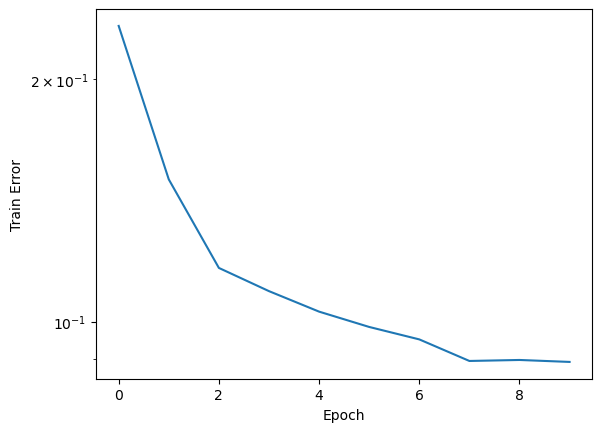

35/35 [==============================] - 0s 3ms/step


0.08819547861993736

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
history = model.fit([train.user_id, train.activity_id], train.rating, epochs=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.activity_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

In [9]:
def predict_preferences(user_id):
    
    user = np.array([user_id for i in range(num_activities)])
    activity = np.array([i for i in range(1, num_activities + 1)])
    predictions = model.predict([user, activity])
    
    return predictions.reshape(-1)

print(predict_preferences(1))

4/4 [==============================] - 0s 5ms/step
[0.293975   0.2969949  0.28709865 0.2950366  0.29417026 0.29725173
 0.30029568 0.2998758  0.29141742 0.3020537  0.30116558 0.29579037
 0.30153707 0.3047589  0.29571256 0.29593325 0.2932455  0.2913435
 0.2957402  0.2963428  0.30028197 0.29822683 0.29356033 0.2942382
 0.3022004  0.29505935 0.29675135 0.30109042 0.2962606  0.29938006
 0.28835872 0.29823062 0.30463096 0.28468287 0.29662058 0.3115257
 0.3030209  0.29473463 0.30155718 0.29771763 0.29815578 0.29678068
 0.29381955 0.29762647 0.2955705  0.2965917  0.29992566 0.300633
 0.29613757 0.2922661  0.2923385  0.29517192 0.3044639  0.2932162
 0.29768014 0.29924592 0.29766876 0.30055505 0.29546767 0.29346395
 0.2951428  0.29532877 0.2979852  0.30203137 0.29675633 0.298552
 0.2959816  0.2987457  0.29368907 0.2941951  0.2991739  0.30289793
 0.29556492 0.2994162  0.29608282 0.29743052 0.2959901  0.29750913
 0.29648042 0.29673004 0.29934913 0.29441047 0.29515424 0.2966884
 0.29824674 0.302918

User ID: 18
True user conditions: 1
4/4 [==============================] - 0s 4ms/step
Top activities: ["Giocare a 'indovina l'oggetto' con scatole sensoriali"
 'Osservare stelle con un piccolo telescopio'
 'Giocare a nascondino con oggetti'
 'Giocare con palloni da calcio o da basket'
 'Esperimenti di miscelazione con colori alimentari e acqua']
Target conditions: [1 0 3 1 3]


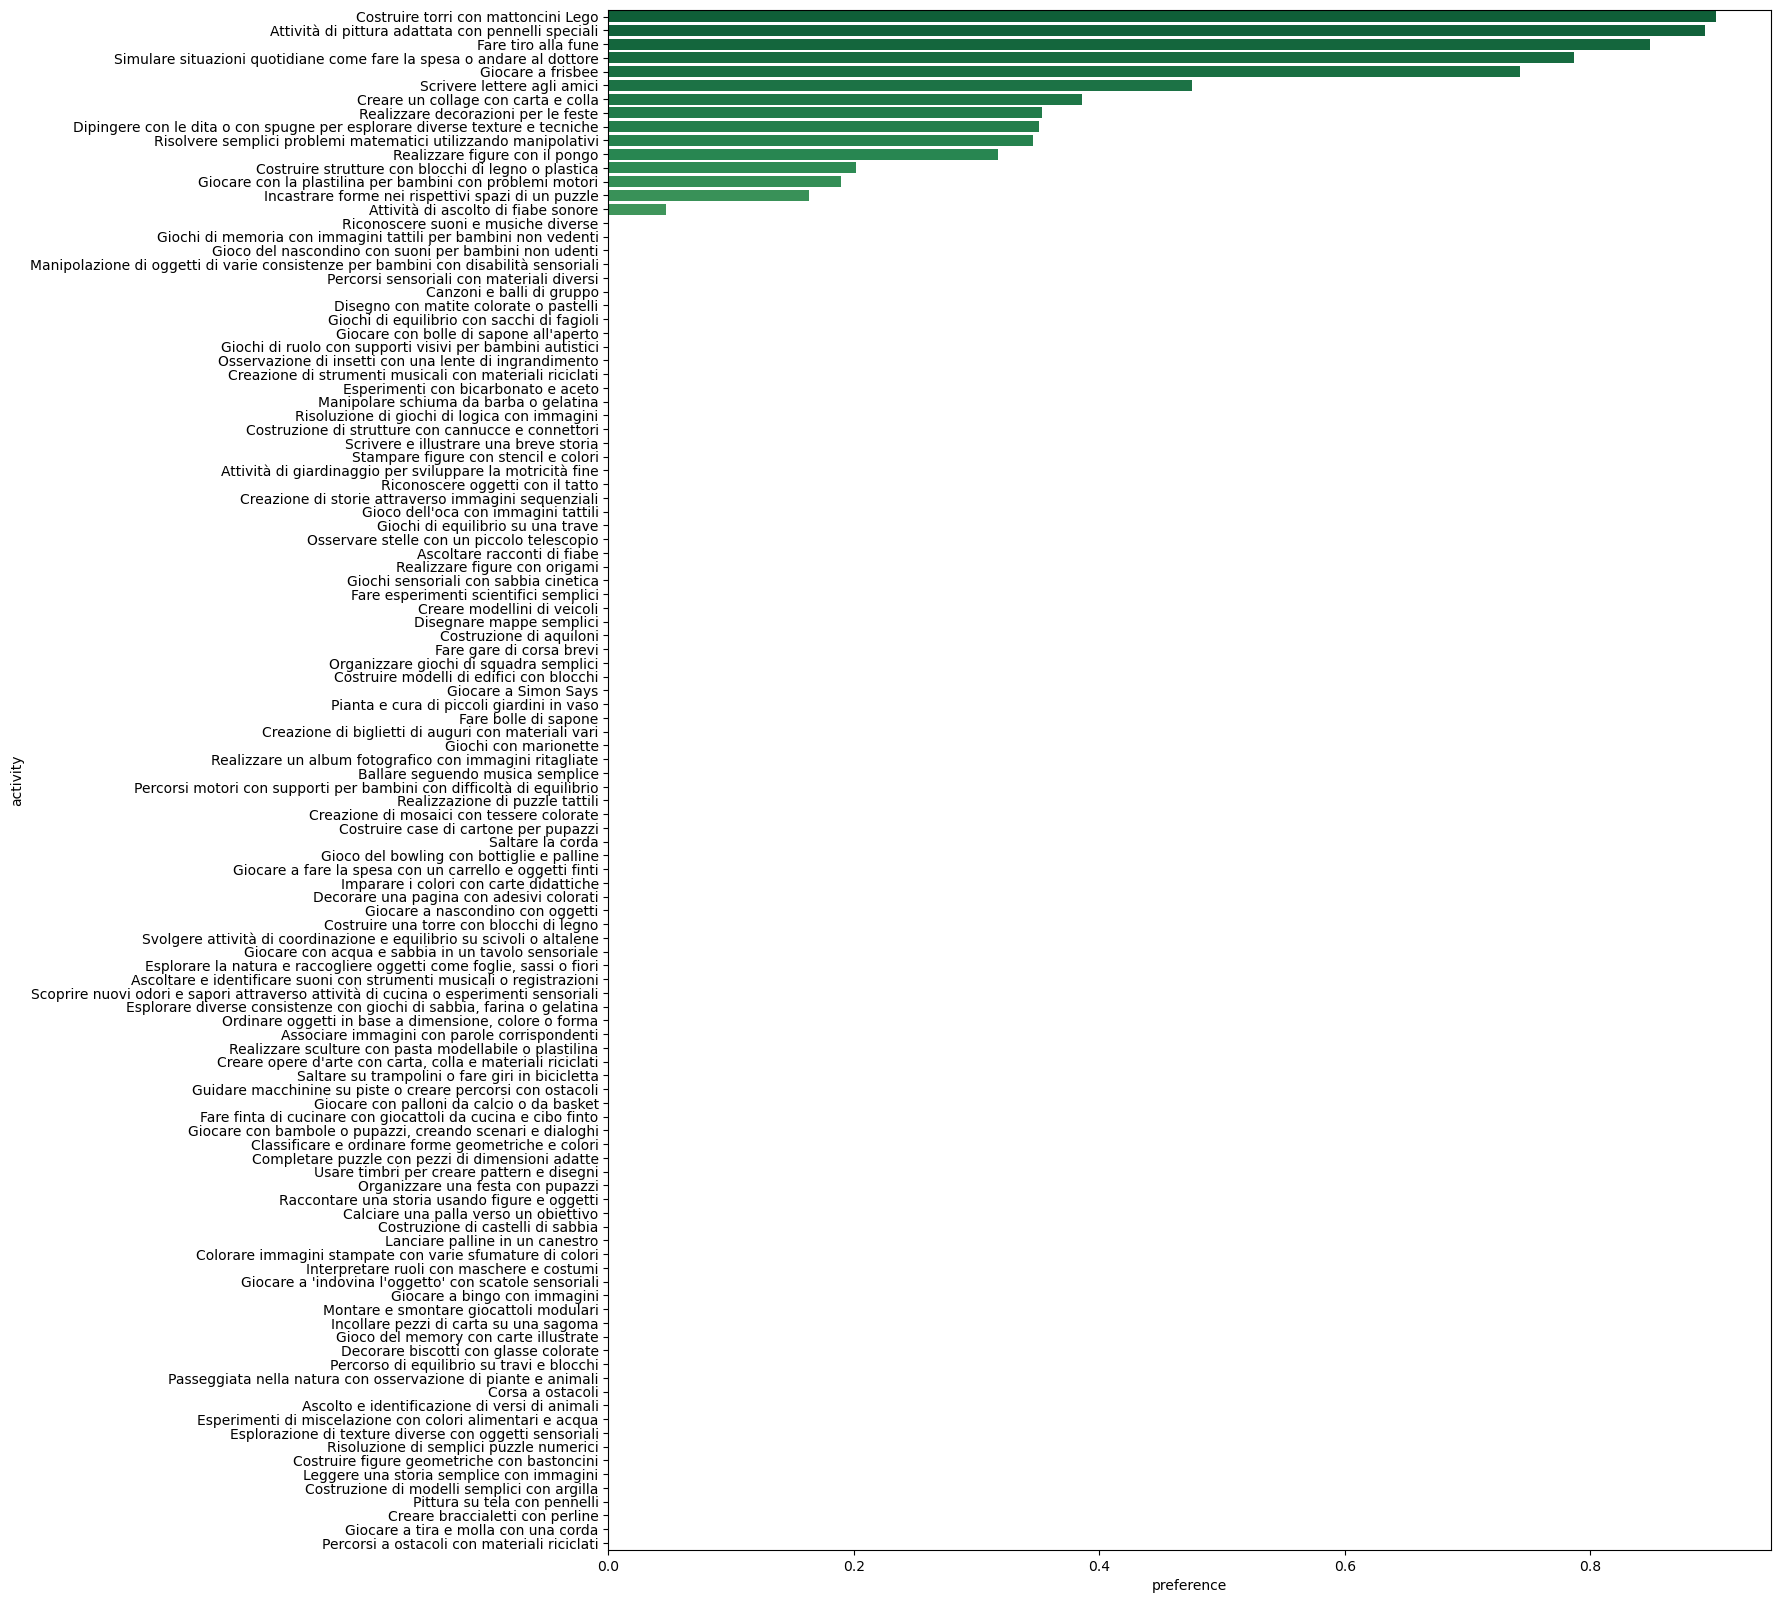

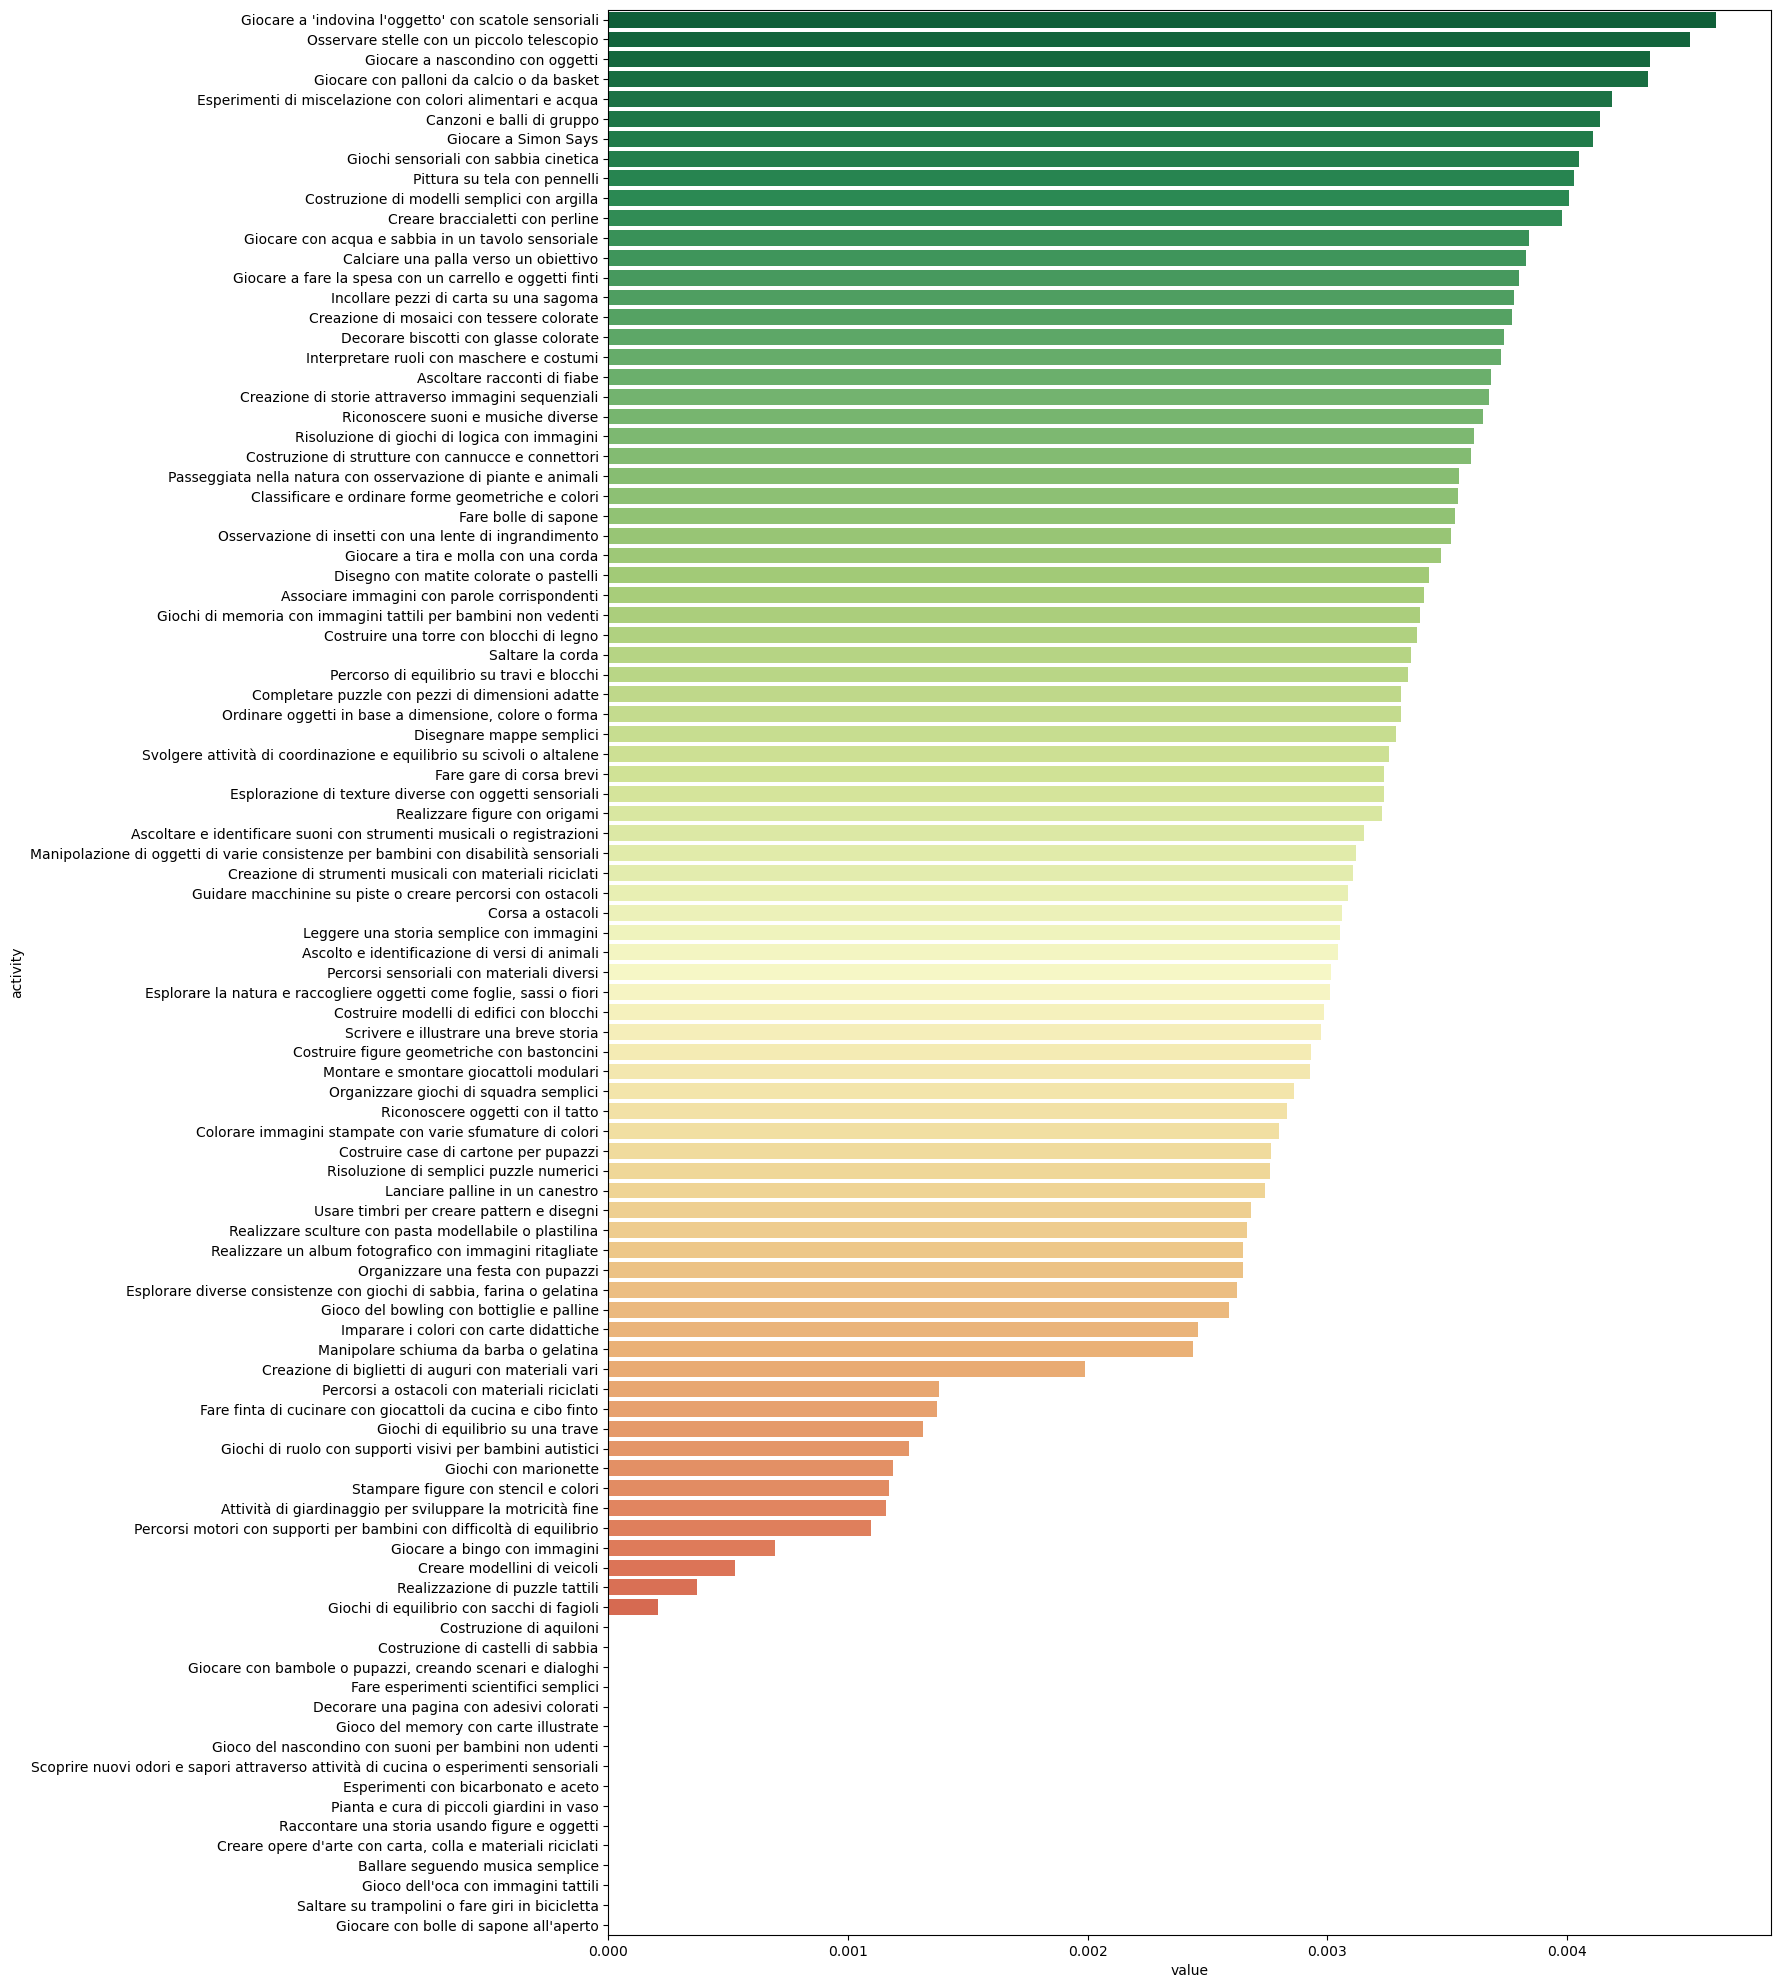

In [61]:
import seaborn as sns

users = pd.read_csv("synthetic-dataset/user.csv")
activities = pd.read_csv("synthetic-dataset/activity.csv", sep='|')
preference_df = pd.read_csv("synthetic-dataset/preference.csv")
user_item_matrix = preference_df.pivot(index='user_id', columns='activity_id', values='preference').fillna(0)

# Adjust preference values
user_item_matrix[user_item_matrix == -1] = np.nan
#user_id = np.random.choice(users['user_id'])
user_id = 18

old_preferences_user = user_item_matrix.loc[user_id].values
old_preferences_user = np.stack((activities['activity'], old_preferences_user), axis=1) 
old_preferences_user = pd.DataFrame(old_preferences_user, columns=['activity','preference'])
old_preferences_user.fillna(0, inplace=True)
fig, ax = plt.subplots(figsize=(15, 20))
#print(old_preferences_user)
# store the activities that the user has not rated yet
not_rated_activities_idxs = old_preferences_user[old_preferences_user['preference'] == 0].index.values
sns.barplot(x='preference', y='activity', ax=ax, data=old_preferences_user.sort_values('preference', ascending=False), palette='RdYlGn_r')

print("User ID:", user_id)

true_user_condition = users[users['user_id'] == user_id].values[0][1]
print("True user conditions:", true_user_condition)

predicted_preferences = predict_preferences(user_id)
# only consider the activities that the user has not rated yet
predicted_preferences = predicted_preferences[not_rated_activities_idxs]
arr = np.stack((activities[activities.index.isin(not_rated_activities_idxs)]['activity'], predicted_preferences), axis=1)
value_for_activity = pd.DataFrame(arr, columns=['activity','value'])
fig, ax = plt.subplots(figsize=(15, 25))
sns.barplot(x='value', y='activity', ax=ax, data=value_for_activity.sort_values('value', ascending=False), palette='RdYlGn_r')


# Find the top 5 activities with the highest predicted preferences
top_activities = value_for_activity.sort_values(by='value', ascending=False).head(5)
top_activities_names = top_activities['activity'].values
print("Top activities:", top_activities_names)

# Get the target condition of the top activities
target_conditions = activities[activities['activity'].isin(top_activities_names)]['target_condition'].values
print("Target conditions:", target_conditions)

### Conversion to TFLite model

Conversione

In [8]:
import tensorflow as tf
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

2024-06-25 13:43:41.760834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2]
	 [[{{node inputs}}]]
2024-06-25 13:43:41.768730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100]
	 [[{{node inputs}}]]
2024-06-25 13:43:41.780548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,50]
	 [[{{node inputs}}]]
2024-06-25 13:43:42

INFO:tensorflow:Assets written to: /tmp/tmpaqmoe33d/assets


INFO:tensorflow:Assets written to: /tmp/tmpaqmoe33d/assets
2024-06-25 13:43:43.171093: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-06-25 13:43:43.171123: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-06-25 13:43:43.171739: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpaqmoe33d
2024-06-25 13:43:43.173706: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-06-25 13:43:43.173718: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpaqmoe33d
2024-06-25 13:43:43.177374: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2024-06-25 13:43:43.184273: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is n

In [9]:
# Caricare il modello TensorFlow Lite
interpreter = tf.lite.Interpreter(model_path='model.tflite')

# Allocare i tensori
interpreter.allocate_tensors()

# Ottenere i dettagli degli input e degli output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepara i dati di input per l'inferenza (esempio con un singolo utente e attività)
user_id = 1
activity_id = 50#il limite è 50

# Normalizza l'input secondo il modello se necessario (qui l'input è già un array 2D)
input_data = {
    'user-input': np.array([[user_id]], dtype=np.float32),
    'activity-input': np.array([[activity_id]], dtype=np.float32)
}

# Impostare i dati di input
interpreter.set_tensor(input_details[0]['index'], input_data['user-input'])
interpreter.set_tensor(input_details[1]['index'], input_data['activity-input'])

# Eseguire l'inferenza
interpreter.invoke()

# Recuperare i risultati
output_data = interpreter.get_tensor(output_details[0]['index'])
print(f"Predicted rating for user {user_id} and activity {activity_id}: {output_data[0][0]}")

Predicted rating for user 1 and activity 50: 0.5285766124725342


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


## Performance evaluation

GPU Utilization: only on colab with the selection of the GPU


Performance with svim

In [10]:
#!pip install pynvml
#!pip install gputil
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import time
import GPUtil
import pynvml
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dropout, Dense, BatchNormalization, concatenate, dot
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

# Inizializza NVML
pynvml.nvmlInit()

# Funzione per monitorare l'utilizzo della GPU
def print_gpu_utilization():
    GPUs = GPUtil.getGPUs()
    for gpu in GPUs:
        handle = pynvml.nvmlDeviceGetHandleByIndex(gpu.id)
        graphics_clock = pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_GRAPHICS)
        sm_clock = pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_SM)
        memory_clock = pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_MEM)
        print(f"GPU {gpu.id}: {gpu.name}")
        print(f"  Utilization: {gpu.load*100:.2f}%")
        print(f"  Memory Used: {gpu.memoryUsed} MB")
        print(f"  Memory Total: {gpu.memoryTotal} MB")
        print(f"  Graphics Clock: {graphics_clock} MHz")
        print(f"  SM Clock: {sm_clock} MHz")
        print(f"  Memory Clock: {memory_clock} MHz")

# Funzione per registrare l'utilizzo della GPU durante l'addestramento
def log_gpu_utilization():
    utilization = []
    memory_used = []
    graphics_clocks = []
    sm_clocks = []
    memory_clocks = []
    GPUs = GPUtil.getGPUs()
    for gpu in GPUs:
        handle = pynvml.nvmlDeviceGetHandleByIndex(gpu.id)
        utilization.append(gpu.load*100)
        memory_used.append(gpu.memoryUsed)
        graphics_clocks.append(pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_GRAPHICS))
        sm_clocks.append(pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_SM))
        memory_clocks.append(pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_MEM))
    return utilization, memory_used, graphics_clocks, sm_clocks, memory_clocks

# Callback per registrare le metriche della GPU
class GPUUtilizationCallback(Callback):
    def __init__(self):
        super(GPUUtilizationCallback, self).__init__()
        self.gpu_utilization = []
        self.gpu_memory = []
        self.graphics_clocks = []
        self.sm_clocks = []
        self.memory_clocks = []

    def on_epoch_end(self, epoch, logs=None):
        utilization, memory_used, graphics_clocks, sm_clocks, memory_clocks = log_gpu_utilization()
        self.gpu_utilization.append(utilization[0])  # Considera solo la prima GPU
        self.gpu_memory.append(memory_used[0])       # Considera solo la prima GPU
        self.graphics_clocks.append(graphics_clocks[0])
        self.sm_clocks.append(sm_clocks[0])
        self.memory_clocks.append(memory_clocks[0])
        print(f"Epoch {epoch+1} GPU Utilization: {utilization[0]}%, Memory Used: {memory_used[0]}MB")
        print(f"  Graphics Clock: {graphics_clocks[0]} MHz")
        print(f"  SM Clock: {sm_clocks[0]} MHz")
        print(f"  Memory Clock: {memory_clocks[0]} MHz")

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')

# Caricamento e pre-elaborazione del dataset
dataset = pd.read_csv("synthetic-dataset/preference.csv", header=1, names=['user_id', 'activity_id', 'rating'])

# Replace -1 with NaN to indicate missing data
dataset.replace(-1, np.nan, inplace=True)

# Calcola la media delle preferenze per ogni utente
mean_user_preferences = dataset.groupby('user_id')['rating'].transform('mean')

# Sostituisci i NaN con la media calcolata per ciascun utente
dataset['rating'] = dataset['rating'].fillna(mean_user_preferences)

# Mischiare i dati
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Map activity ID to [1, num_activities]
activity_id_to_new_id = dict()
id = 1
for index, row in dataset.iterrows():
    if activity_id_to_new_id.get(row['activity_id']) is None:
        activity_id_to_new_id[row['activity_id']] = id
        dataset.at[index, 'activity_id'] = id
        id += 1
    else:
        dataset.at[index, 'activity_id'] = activity_id_to_new_id.get(row['activity_id'])

num_users = len(dataset.user_id.unique())
num_activities = len(dataset.activity_id.unique())
train, test = train_test_split(dataset, test_size=0.2)

print('Number of activities', num_activities)
print('Number of users', num_users)
print(activity_id_to_new_id)

latent_dim = 1

# Define inputs
activity_input = Input(shape=[1], name='activity-input')
user_input = Input(shape=[1], name='user-input')

# MLP Embeddings
activity_embedding_mlp = Embedding(num_activities + 1, latent_dim, name='activity-embedding-mlp')(activity_input)
activity_vec_mlp = Flatten(name='flatten-activity-mlp')(activity_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
activity_embedding_mf = Embedding(num_activities + 1, latent_dim, name='activity-embedding-mf')(activity_input)
activity_vec_mf = Flatten(name='flatten-activity-mf')(activity_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = concatenate([activity_vec_mlp, user_vec_mlp], name='concat')
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = dot([activity_vec_mf, user_vec_mf], axes=1, name='pred-mf')
combine_mlp_mf = concatenate([pred_mf, pred_mlp], name='combine-mlp-mf')

# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, activity_input], result)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_absolute_error')

# Monitoraggio delle prestazioni della GPU durante l'addestramento
gpu_callback = GPUUtilizationCallback()
train_losses = []
epoch_times = []
num_epochs = 10

for epoch in range(num_epochs):
    start_time = time.time()

    history = model.fit([train.user_id, train.activity_id], train.rating, epochs=1, verbose=0, callbacks=[gpu_callback])

    end_time = time.time()
    epoch_time = end_time - start_time

    train_losses.append(history.history['loss'][0])
    epoch_times.append(epoch_time)

    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_time:.2f} seconds")

# Plotting GPU utilization
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), gpu_callback.gpu_utilization, marker='o')
plt.title('GPU Utilization Over Time')
plt.xlabel('Epoch')
plt.ylabel('Utilization (%)')
plt.grid(True)
plt.show()

# Plotting GPU memory usage
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), gpu_callback.gpu_memory, marker='o')
plt.title('GPU Memory Usage Over Time')
plt.xlabel('Epoch')
plt.ylabel('Memory Used (MB)')
plt.grid(True)
plt.show()

# Plotting GPU graphics clock speed
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), gpu_callback.graphics_clocks, marker='o')
plt.title('GPU Graphics Clock Over Time')
plt.xlabel('Epoch')
plt.ylabel('Graphics Clock (MHz)')
plt.grid(True)
plt.show()

# Plotting GPU SM clock speed
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), gpu_callback.sm_clocks, marker='o')
plt.title('GPU SM Clock Over Time')
plt.xlabel('Epoch')
plt.ylabel('SM Clock (MHz)')
plt.grid(True)
plt.show()

# Plotting GPU memory clock speed
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), gpu_callback.memory_clocks, marker='o')
plt.title('GPU Memory Clock Over Time')
plt.xlabel('Epoch')
plt.ylabel('Memory Clock (MHz)')
plt.grid(True)
plt.show()

# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.yscale('log')
plt.grid(True)
plt.show()

# Plotting epoch times
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_times, marker='o')
plt.title('Epoch Time Over Time')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.show()

y_hat = np.round(model.predict([test.user_id, test.activity_id]), decimals=2)
y_true = test.rating
print("Mean Absolute Error:", mean_absolute_error(y_true, y_hat))

# Cleanup NVML
pynvml.nvmlShutdown()


ModuleNotFoundError: No module named 'GPUtil'

Performance CPU

CPU: 11th Gen Intel(R) Core(TM) i9-11900H @ 2.50GHz
Memory usage at start: 954.17 MB
Number of activities 112
Number of users 50
{73.0: 1, 8.0: 2, 69.0: 3, 81.0: 4, 102.0: 5, 83.0: 6, 45.0: 7, 80.0: 8, 29.0: 9, 11.0: 10, 98.0: 11, 18.0: 12, 63.0: 13, 48.0: 14, 101.0: 15, 47.0: 16, 52.0: 17, 92.0: 18, 65.0: 19, 25.0: 20, 85.0: 21, 31.0: 22, 49.0: 23, 99.0: 24, 58.0: 25, 86.0: 26, 10.0: 27, 33.0: 28, 67.0: 29, 38.0: 30, 26.0: 31, 109.0: 32, 37.0: 33, 23.0: 34, 88.0: 35, 64.0: 36, 77.0: 37, 17.0: 38, 7.0: 39, 56.0: 40, 76.0: 41, 39.0: 42, 96.0: 43, 84.0: 44, 4.0: 45, 105.0: 46, 6.0: 47, 27.0: 48, 53.0: 49, 70.0: 50, 106.0: 51, 61.0: 52, 24.0: 53, 90.0: 54, 51.0: 55, 79.0: 56, 72.0: 57, 36.0: 58, 89.0: 59, 95.0: 60, 74.0: 61, 13.0: 62, 30.0: 63, 44.0: 64, 87.0: 65, 97.0: 66, 32.0: 67, 59.0: 68, 21.0: 69, 14.0: 70, 40.0: 71, 68.0: 72, 93.0: 73, 9.0: 74, 71.0: 75, 91.0: 76, 20.0: 77, 100.0: 78, 66.0: 79, 108.0: 80, 34.0: 81, 46.0: 82, 57.0: 83, 2.0: 84, 22.0: 85, 82.0: 86, 15.0: 87, 60.0: 88

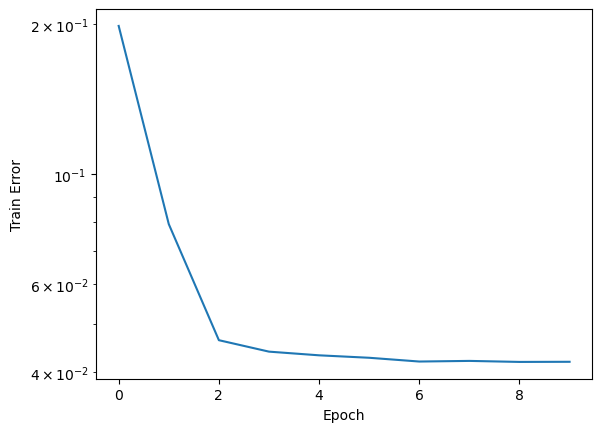

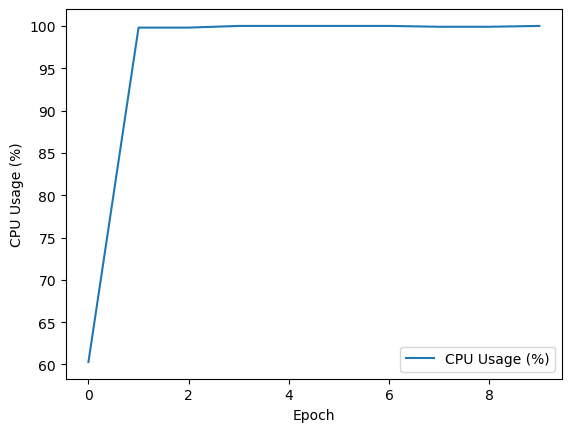

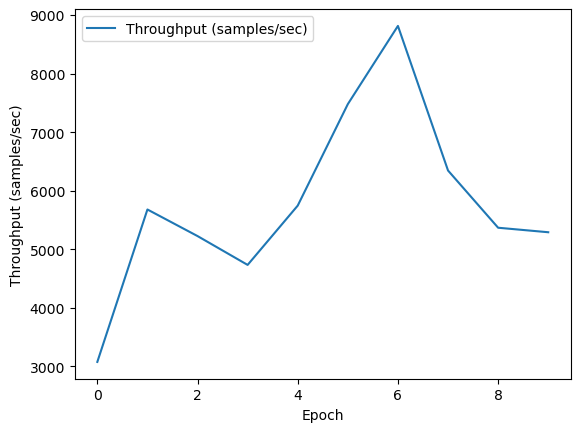

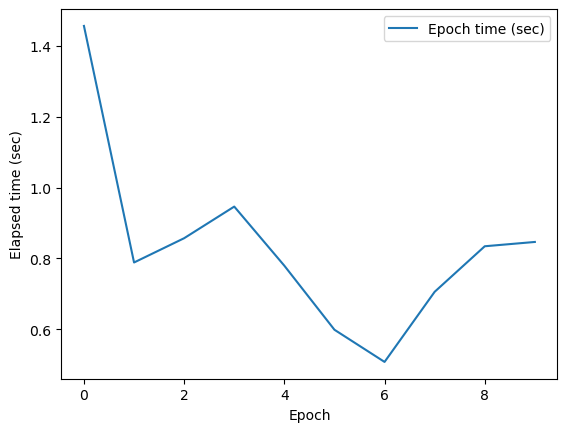

35/35 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.039467939720115426


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import psutil
import time
import tensorflow as tf
import cpuinfo
import os

# Function to monitor CPU usage
def monitor_cpu():
    cpu_percent = psutil.cpu_percent(interval=0.1)
    return cpu_percent

# Function to monitor memory usage
def monitor_memory():
    memory_info = process.memory_info()
    return memory_info.data / 1e6 # in MB

pid = os.getpid()
process = psutil.Process(pid)

cpu_name = cpuinfo.get_cpu_info()['brand_raw'] # get only the brand name
print("CPU:", cpu_name)

time_start = time.time()
memory_usage_start = monitor_memory()
# set the reference for cpu usage
monitor_cpu()

time_start = time.time()
memory_usage_start = monitor_memory()
# set the reference for cpu usage
monitor_cpu()

print("Memory usage at start: %.2f MB"% memory_usage_start)

############## NORMALIZZARE IL DATASET ##############

dataset = pd.read_csv("synthetic-dataset/preference.csv", header=1, names=['user_id', 'activity_id', 'rating'])

# Replace -1 with NaN to indicate missing data
dataset.replace(-1, np.nan, inplace=True)

# Calcola la media delle preferenze per ogni utente
mean_user_preferences = dataset.groupby('user_id')['rating'].transform('mean')

# Sostituisci i NaN con la media calcolata per ciascun utente
dataset['rating'] = dataset['rating'].fillna(mean_user_preferences)

# Mischiare i dati
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Need to map activity ID to [1, num_activities], assegna nuovi id ai attività per contare numero di attività e numero di utenti
activity_id_to_new_id = dict()
id = 1
for index, row in dataset.iterrows():
    if activity_id_to_new_id.get(row['activity_id']) is None:
        activity_id_to_new_id[row['activity_id']] = id
        dataset.at[index, 'activity_id'] = id
        id += 1
    else:
        dataset.at[index, 'activity_id'] = activity_id_to_new_id.get(row['activity_id'])

num_users = len(dataset.user_id.unique())
num_activities = len(dataset.activity_id.unique())
train, test = train_test_split(dataset, test_size=0.2)

print('Number of activities', num_activities)
print('Number of users', num_users)
print(activity_id_to_new_id)

from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dropout, Dense, BatchNormalization, concatenate, dot
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

latent_dim = 1  # capire se mettere 1 o 10

# Define inputs
activity_input = Input(shape=[1], name='activity-input')
user_input = Input(shape=[1], name='user-input')

# MLP Embeddings
activity_embedding_mlp = Embedding(num_activities + 1, latent_dim, name='activity-embedding-mlp')(activity_input)
activity_vec_mlp = Flatten(name='flatten-activity-mlp')(activity_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
activity_embedding_mf = Embedding(num_activities + 1, latent_dim, name='activity-embedding-mf')(activity_input)
activity_vec_mf = Flatten(name='flatten-activity-mf')(activity_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = concatenate([activity_vec_mlp, user_vec_mlp], name='concat')
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = dot([activity_vec_mf, user_vec_mf], axes=1, name='pred-mf')
combine_mlp_mf = concatenate([pred_mf, pred_mlp], name='combine-mlp-mf')

# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, activity_input], result)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_absolute_error')

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Variables to store CPU usage and throughput per epoch
cpu_usage = []
throughput = []
epoch_times = []

class PerformanceCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()
        self.cpu_start = psutil.cpu_percent(interval=None)

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time
        cpu_used = psutil.cpu_percent(interval=None) # cpu_percent() automatically calculates CPU usage since the last call
        samples_per_sec = len(train) / elapsed_time

        cpu_usage.append(cpu_used)
        throughput.append(samples_per_sec)

        epoch_times.append(elapsed_time)

        print(f"Epoch {epoch + 1}: CPU Usage: {cpu_used:.2f}%, Throughput: {samples_per_sec:.2f} samples/sec")

performance_callback = PerformanceCallback()
history = model.fit([train.user_id, train.activity_id], train.rating, epochs=10, callbacks=[performance_callback])

elapsed_time = time.time() - time_start
cpu_usage_training = np.array(cpu_usage).mean()
memory_usage_end = monitor_memory()
print("Memory usage at end: %.2f MB"% memory_usage_end)
memory_used = memory_usage_end - memory_usage_start
print("Memory used: %.2f MB"% memory_used)
print("CPU usage during training: %.2f%%"% cpu_usage_training)
print("Elapsed time for training: %.3f seconds"% elapsed_time)

# Plot training error
plt.figure()
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

# Plot CPU usage
plt.figure()
plt.plot(cpu_usage, label='CPU Usage (%)')
plt.xlabel("Epoch")
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.show()

# Plot throughput
plt.figure()
plt.plot(throughput, label='Throughput (samples/sec)')
plt.xlabel("Epoch")
plt.ylabel("Throughput (samples/sec)")
plt.legend()
plt.show()

# Plot epoch times
plt.figure()
plt.plot(epoch_times, label='Epoch time (sec)')
plt.xlabel("Epoch")
plt.ylabel("Elapsed time (sec)")
plt.legend()
plt.show()

y_hat = np.round(model.predict([test.user_id, test.activity_id]), decimals=2)
y_true = test.rating
print("Mean Absolute Error:", mean_absolute_error(y_true, y_hat))

In [13]:
# total elapsed time
total_time = sum(epoch_times)
print(f"Total elapsed time: {total_time:.2f} seconds")

Total elapsed time: 11.47 seconds


### Inference (single user)

In [13]:

user_id = np.random.choice(test.user_id.unique())

# Measure start time and CPU usage
start_time = time.time()
memory_usage_start = monitor_memory()

top_activities = np.argsort(-model.predict([np.array([user_id] * num_activities), np.arange(1, num_activities + 1)]).flatten())[:5]

# Measure end time
end_time = time.time()
memory_usage_end = monitor_memory()

# Calculate total execution time and CPU usage
execution_time = end_time - start_time
cpu_usage = monitor_cpu()

print("Total execution time: %.3f seconds" % execution_time)
print("CPU usage: %.2f%%" % cpu_usage)
print("Memory usage: %.2f MB" % (memory_usage_end - memory_usage_start))

print("Top 5 activities for user %d:" % user_id, top_activities)

4/4 [==============================] - 0s 10ms/step
Total execution time: 0.159 seconds
CPU usage: 100.00%
Memory usage: 8.52 MB
Top 5 activities for user 23: [105  12  70 111  82]
